# Capstone Project - The Battle of Neighborhoods


### Introduction

Suppose you are visiting a new country and wants to eat a lot of Italian food. How would you choose which cities to visit based on the quality of Italian venues and on the sheer quantity of restaurants where you can eat Italian food? 

This project aims to, given some cities, provide the best cities to visit based on the quality/quantity of restaurants of a chosen kind. It will target tourists that cares about the quality of the food their are going to eat during their trips.

### Data

This project will scrap data from Foursquare dataframe to get a given type of restaurant in a list of cities. As an test case, 4 cities will be considered:
* Maceio, AL
* Aracaju, SE
* Teresina, PI
* Fortaleza, CE
* Recife, PE

All these cities are located in the northeast of Brazil and are considered great vacation destinies with gorgeous beaches and offering high quality services for a low cost.

The type of cuisine considered was Italian, but the analisys made here can be replicated for any type of restaurant listed on Foursquare.

### Methodology

* List possible destinies for a trip.
* List the type of cousine you want to experience during the trip
* Using FourSquare, find all venues of the chosen type on the selected cities
* Using FourSquare, get the ratings of each venue
* Classify the cities based on the number of Venues of the chosen kind
* Use FourSquare Ratios to compare each city

In [190]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests # library to handle requests
import folium # map rendering library

print('Libraries imported.')
restaurant_type = 'Italian'

Libraries imported.


In [2]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20200304'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CNECYMIOQKJZAS2SVAAYD3YVLRCUAGXUASCQ54PE1KGWUZH3
CLIENT_SECRET:UY5QH5IQ4DL3SADMTHD4KLBD2O14R5CIMLLYWPT0U4IRTMAG


Retrieving venues data for each city using foursquare API

In [193]:
# type your answer here
Limit = 500 # Maximum is 100
cities = ["Maceio, AL", 'Aracaju, SE', 'Teresina, PI', 'Fortaleza, CE', 'Recife, PE']
results = {}
for city in cities:
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        city,
        Limit,
        "4bf58dd8d48988d110941735") # ITALIAN PLACE CATEGORY ID
    results[city] = requests.get(url).json()

In [194]:
df_venues={}
for city in cities:
    venues = pd.json_normalize(results[city]['response']['groups'][0]['items'])
    df_venues[city] = venues[['venue.name', 'venue.id', 'venue.location.address', 'venue.location.lat', 'venue.location.lng']]
    df_venues[city].columns = ['Name', 'ID', 'Address', 'Lat', 'Lng']

Generating maps locations for better visualization of the cities Italian venues

In [195]:
maps = {}
restaurants_total = []
for city in cities:
    city_lat = np.mean([results[city]['response']['geocode']['geometry']['bounds']['ne']['lat'],
                        results[city]['response']['geocode']['geometry']['bounds']['sw']['lat']])
    city_lng = np.mean([results[city]['response']['geocode']['geometry']['bounds']['ne']['lng'],
                        results[city]['response']['geocode']['geometry']['bounds']['sw']['lng']])
    maps[city] = folium.Map(location=[city_lat, city_lng], zoom_start=11)

    # add markers to map
    for lat, lng, label in zip(df_venues[city]['Lat'], df_venues[city]['Lng'], df_venues[city]['Name']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(maps[city])  
    restaurants_total.append(results[city]['response']['totalResults'])

Ploting number of restaurants for each city

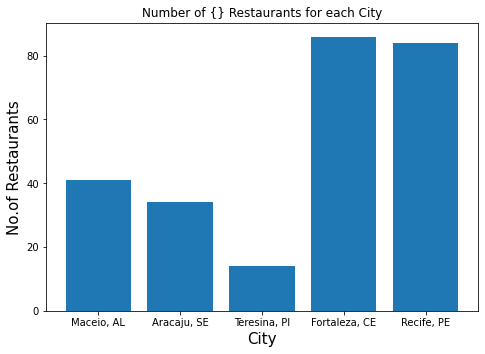

In [196]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(cities,restaurants_total)
plt.title('Number of {} Restaurants for each City')
plt.xlabel('City', fontsize = 15)
plt.ylabel('No.of Restaurants', fontsize=15)

plt.show()

We see that Fortaleza has the highest number of italian restaurants of the cities we are analyzing.

In [197]:
maps[cities[0]]

In [198]:
maps[cities[1]]

In [199]:
maps[cities[2]]

In [200]:
maps[cities[3]]

In [201]:
maps[cities[4]]

Calculation of mean distances from mean coordinates. 

For this calculation we first locate the mean location of the Italian places. Then, we calculate the mean distance of this location for every Italian place.

This way, one can choose to stay in a hotel next to the mean location of the Italian places, and will, in average, have to walk the mean distance given bellow.

This data will inform us the city with better access to Italian places, by minimizing the travel distance between the hotel and the restaurant.

In [202]:
maps = {}
for city in cities:
    city_lat = np.mean([results[city]['response']['geocode']['geometry']['bounds']['ne']['lat'],
                        results[city]['response']['geocode']['geometry']['bounds']['sw']['lat']])
    city_lng = np.mean([results[city]['response']['geocode']['geometry']['bounds']['ne']['lng'],
                        results[city]['response']['geocode']['geometry']['bounds']['sw']['lng']])
    maps[city] = folium.Map(location=[city_lat, city_lng], zoom_start=11)
    venues_mean_coor = [df_venues[city]['Lat'].mean(), df_venues[city]['Lng'].mean()] 
    # add markers to map
    for lat, lng, label in zip(df_venues[city]['Lat'], df_venues[city]['Lng'], df_venues[city]['Name']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(maps[city])
        folium.PolyLine([venues_mean_coor, [lat, lng]], color="green", weight=1.5, opacity=0.5).add_to(maps[city])
    
    label = folium.Popup("Mean Co-ordinate", parse_html=True)
    folium.CircleMarker(
        venues_mean_coor,
        radius=10,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(maps[city])

    print(city)
    print("Mean Distance from Mean coordinates")
    print(np.mean(np.apply_along_axis(lambda x: np.linalg.norm(x - venues_mean_coor),1,df_venues[city][['Lat','Lng']].values)))


Maceio, AL
Mean Distance from Mean coordinates
0.033649453626477116
Aracaju, SE
Mean Distance from Mean coordinates
0.028484988264272714
Teresina, PI
Mean Distance from Mean coordinates
0.012530628699372442
Fortaleza, CE
Mean Distance from Mean coordinates
0.035470805664267455
Recife, PE
Mean Distance from Mean coordinates
0.042521865072031984


Terezina is the city with the least ammount of travel if one would be hosted on the mean place of the Italian places.

Getting the Ratings for each venue

In [142]:
import itertools as it

column_names=['ID','Name','Likes','Rating','Tips']

df = pd.DataFrame(columns = column_names)

venue_ids = []
for city in cities:
    venue_ids = venue_ids + df_venues[city]['ID'].tolist()

for venueID in venue_ids:
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            venueID, 
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()
    venue_data = results['response']['venue']
    venue_details=[]
    try:
        venue_id = venue_data['id']
        venue_name = venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    
    dfaux = pd.DataFrame(venue_details,columns=column_names)
    df = pd.concat([dfaux, df])


KeyError: 'venue'

Transforming the data into floats in order to better compare Ratings

In [186]:
df['Likes']=df['Likes'].astype('float64')
df['Tips']=df['Tips'].astype('float64')
df = df.reset_index(drop=True)

The best venue based on Likes counts.

In [187]:
df.iloc[[df['Likes'].idxmax()]]

,ID,Name,Likes,Rating,Tips
22,52af5db111d279ae95906749,Parmegianno,858.0,8.3,495.0


The best venue based on Tips counts.

In [188]:
df.iloc[[df['Tips'].idxmax()]]

,ID,Name,Likes,Rating,Tips
22,52af5db111d279ae95906749,Parmegianno,858.0,8.3,495.0


The best venue based on Ratings.

In [189]:
df.iloc[[df['Rating'].idxmax()]]

,ID,Name,Likes,Rating,Tips
29,4d3ccc91d2c8f04d02f56472,Del Popollo,252.0,9.2,133.0
